# **DeepFake Detection Using Vision Transformer (ViT's)**

In [9]:
import os
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
from tqdm import tqdm
import torch.optim as optim
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, roc_auc_score, roc_curve
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import ConcatDataset
from torchvision.utils import make_grid
import random
import numpy as np


In [4]:
# Custom dataset class for loading images
class ImageDataset(Dataset):
    def __init__(self, real_dir, fake_dir, transform=None):
        self.real_dir = real_dir
        self.fake_dir = fake_dir
        self.transform = transform
        
        # Get image paths for real and fake images
        self.real_images = os.listdir(real_dir)
        self.fake_images = os.listdir(fake_dir)
        
        # Create full paths for the images and assign labels
        self.image_paths = [os.path.join(real_dir, img) for img in self.real_images] + \
                           [os.path.join(fake_dir, img) for img in self.fake_images]
        
        # 0 for real, 1 for fake
        self.labels = [0] * len(self.real_images) + [1] * len(self.fake_images)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(image_path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

# **Data Augmentations**
This block of code defines the **data augmentation strategy** for training images, which helps improve the model’s robustness and generalization. 

Key changes and their purposes:
- **RandomHorizontalFlip** and **RandomVerticalFlip**: Introduce random flipping, simulating different orientations of the images.
- **RandomRotation (up to 30 degrees)**: Adds more variability by allowing larger rotations, making the model learn from diverse perspectives.
- **ColorJitter**: Adds more variance in brightness, contrast, saturation, and hue, helping the model handle different lighting conditions.
- **RandomAffine**: Slightly increases random translations and scaling, making the model more adaptable to small shifts and resizes in the image.
- **RandomResizedCrop**: Varies the size and position of the crop, simulating objects of different scales within images.

These augmentations aim to prevent overfitting by introducing a wider range of transformations, helping the model become more resilient to variations in real-world data. 
The validation and test transformations remain unchanged since augmentation is not applied during evaluation.

In [5]:
# Adjusted Data Augmentation for Training
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resizes images to 224x224
    transforms.RandomHorizontalFlip(p=0.5),  # Flip images horizontally with a probability of 0.5
    transforms.RandomVerticalFlip(p=0.2),  # Flip images vertically with a probability of 0.2 (new addition)
    transforms.RandomRotation(30),  # Increase rotation variability to up to 30 degrees
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.2),  # More variance in color adjustments
    transforms.RandomAffine(degrees=10, translate=(0.2, 0.2), scale=(0.8, 1.2)),  # Slightly more affine transformation
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # RandomResizedCrop for more variability in object sizes
    transforms.ToTensor(),  # Converts image to tensor, scales pixel values to [0, 1]
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize with ImageNet stats
])

# No changes needed for validation/test set as data augmentation is only for training
val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# **Data Loading and Training**

In [6]:
from sklearn.model_selection import train_test_split

# Define paths to your real and fake image directories
real_dir = 'final_cleaned_dataset/resized_data/rezised_real' # GAN Data has been added to this
fake_dir = 'final_cleaned_dataset/resized_data/rezised_fake' # GAN Data has been added to this
# gan_real = 'celebrity_pairs/celebrity_dataset_real'
# gan_fake = 'celebrity_pairs/celebrity_dataset_real'

# Create the full dataset
full_dataset = ImageDataset(real_dir, fake_dir, transform=train_transform)

# Split the dataset into training (70%), validation (15%), and testing (15%)
train_indices, test_indices = train_test_split(range(len(full_dataset)), test_size=0.3, random_state=42, stratify=full_dataset.labels)
# Using stratification to ensure the class balance remains consistent between the training and testing sets.
val_indices, test_indices = train_test_split(test_indices, test_size=0.5, random_state=42, stratify=[full_dataset.labels[i] for i in test_indices]) 

# Create Subsets for train/val/test
train_dataset = torch.utils.data.Subset(full_dataset, train_indices)
val_dataset = torch.utils.data.Subset(full_dataset, val_indices)
test_dataset = torch.utils.data.Subset(full_dataset, test_indices)

# DataLoaders for each set
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [22]:
# Define mean and std for unnormalization (ImageNet stats)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Define individual transformations for visualization
visualization_transforms = {
    'Original': transforms.Resize((224, 224)),
    'Horizontal Flip': transforms.RandomHorizontalFlip(p=1.0),
    'Vertical Flip': transforms.RandomVerticalFlip(p=1.0),
    'Rotation': transforms.RandomRotation(30),
    'Color Jitter': transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.2),
    'Affine Transform': transforms.RandomAffine(degrees=10, translate=(0.2, 0.2), scale=(0.8, 1.2)),
    'Resized Crop': transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
}

# Function to unnormalize a tensor image for visualization (fix)
def unnormalize(tensor, mean, std):
    """
    Unnormalizes a tensor image by reversing the normalization applied during preprocessing.
    
    Args:
        tensor (Tensor): Normalized image tensor.
        mean (list): List of mean values for each channel used during normalization.
        std (list): List of standard deviation values for each channel used during normalization.
        
    Returns:
        np.ndarray: Unnormalized image in numpy format.
    """
    tensor = tensor.clone()  # Clone to avoid modifying the original tensor
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)  # Reverse the normalization
    return tensor

# Function to visualize transformations without normalization
def visualize_transformations(dataset, num_images=5):
    """
    Visualizes individual and combined data augmentations on random training images without applying normalization.

    Args:
        dataset (Dataset): The dataset from which images are randomly selected.
        num_images (int): Number of random images to visualize (default: 5).

    Returns:
        None
    """
    # Select random indices from the training dataset
    indices = random.sample(range(len(dataset)), num_images)

    for idx in indices:
        image, label = dataset[idx]  # Get image and label from the dataset

        # Convert tensor to PIL image for visualization (before any transformation)
        image = transforms.ToPILImage()(unnormalize(image, mean, std))  # Unnormalize before converting to PIL

        fig, axes = plt.subplots(1, len(visualization_transforms) + 1, figsize=(20, 5))
        fig.suptitle(f'Visualizing Transformations (Image Index: {idx}, Label: {"Fake" if label else "Real"})', fontsize=16)

        # Apply and visualize each transformation
        for ax, (name, transform) in zip(axes, visualization_transforms.items()):
            if name == 'Original':
                transformed_image = image
            else:
                transformed_image = transform(image)

            # Convert transformed image to numpy format for plotting
            np_image = np.array(transformed_image) / 255.0  # Rescale to [0, 1] for visualization

            ax.imshow(np_image)
            ax.set_title(name)
            ax.axis('off')

        # Apply the full set of transformations without normalization for comparison
        combined_transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.2),
            transforms.RandomRotation(30),
            transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.2),
            transforms.RandomAffine(degrees=10, translate=(0.2, 0.2), scale=(0.8, 1.2)),
            transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
        ])

        combined_image = combined_transform(image)

        # Convert combined image to numpy for visualization without unnormalization
        combined_image = np.array(combined_image) / 255.0
        combined_image = np.clip(combined_image, 0, 1)

        axes[-1].imshow(combined_image)
        axes[-1].set_title('Combined')
        axes[-1].axis('off')

        plt.tight_layout()
        plt.show()


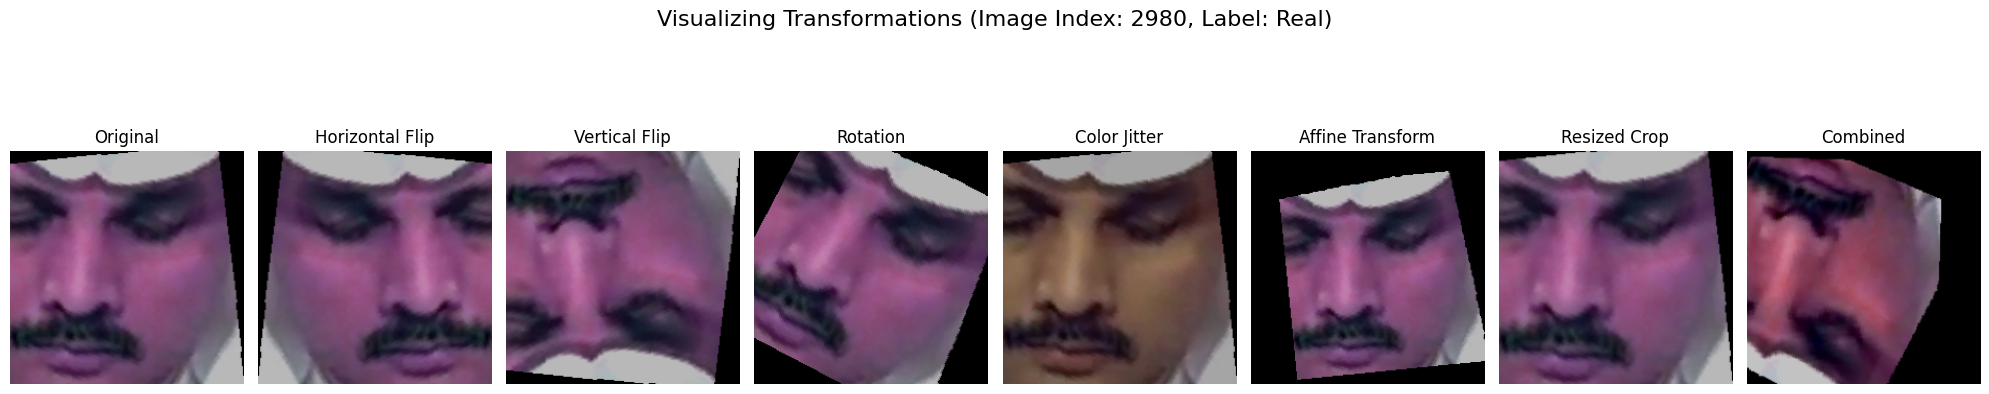

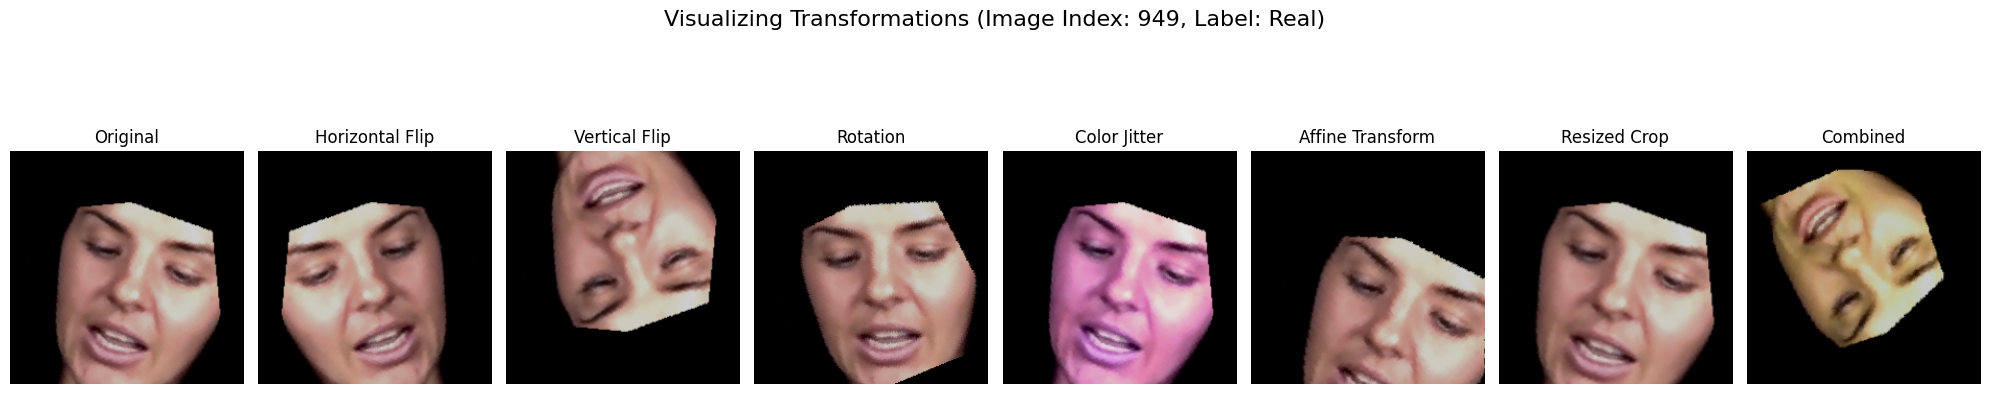

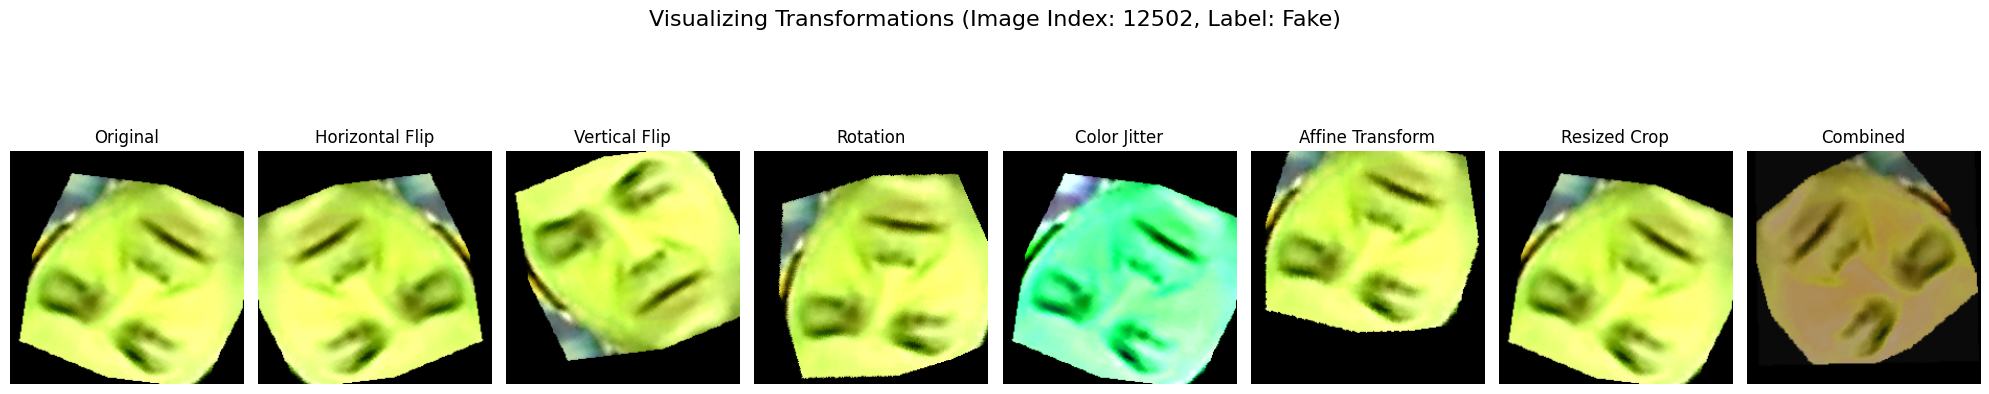

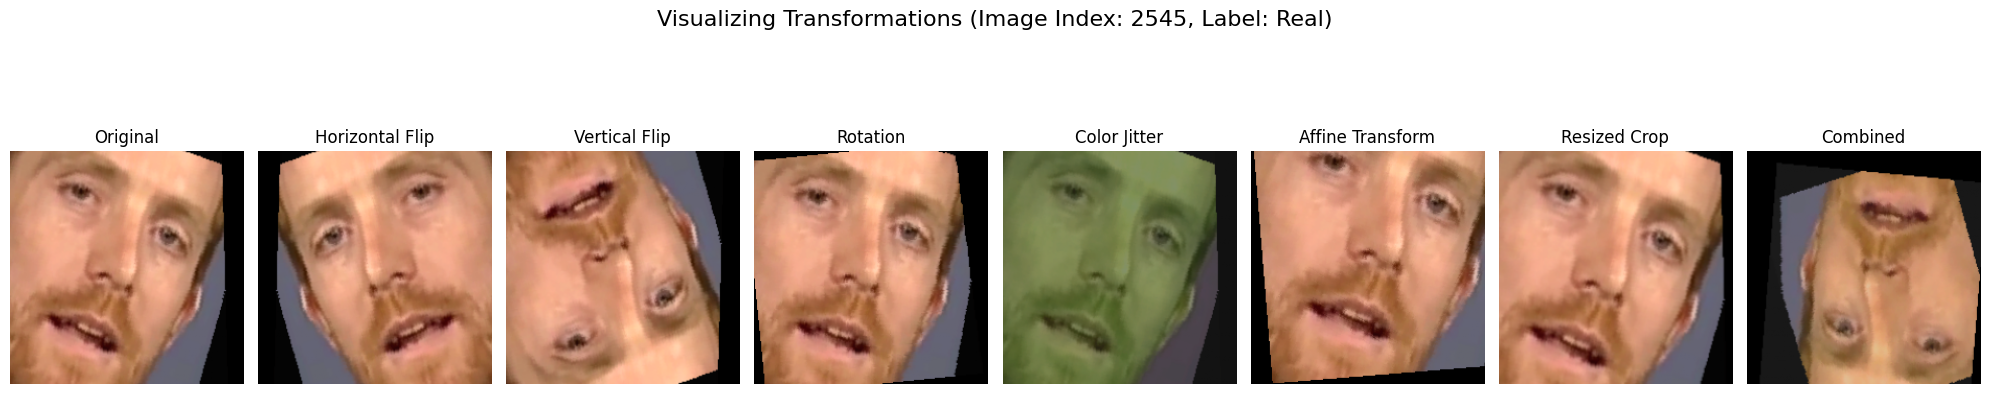

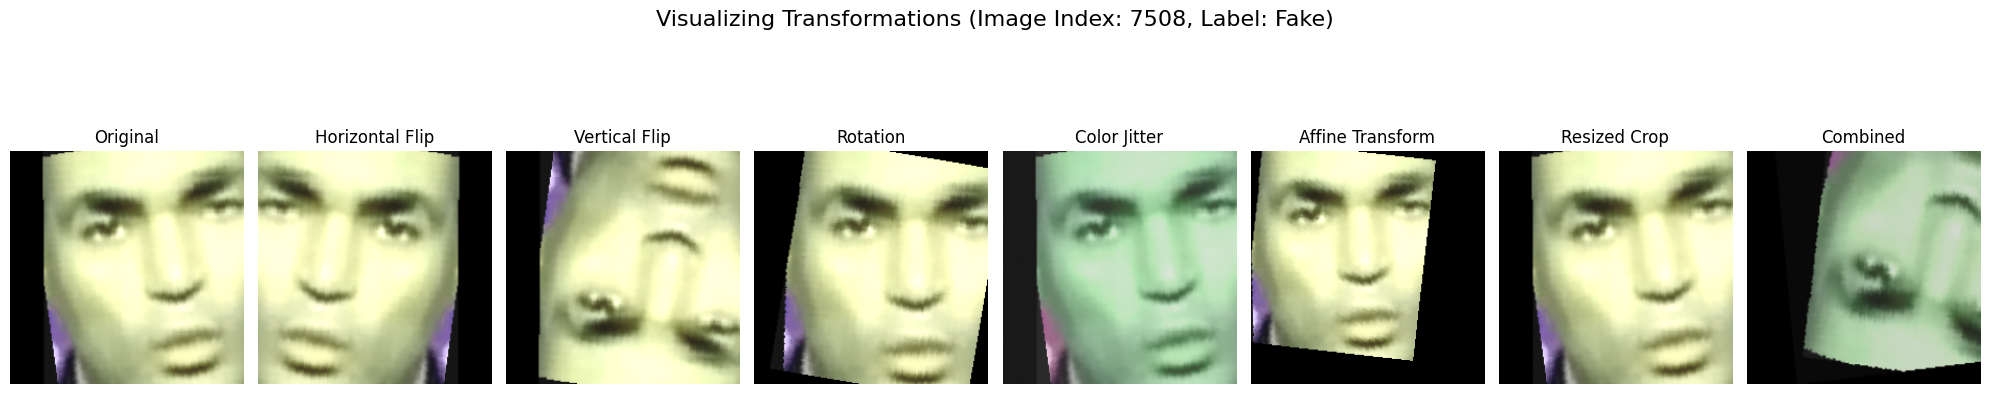

In [27]:
# Call the function to visualize transformations on 5 random images from the training dataset
visualize_transformations(full_dataset, num_images=5)

In [28]:
from transformers import AutoModelForImageClassification, AutoImageProcessor

# Load the pretrained ViT model for binary classification
processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224")
model = AutoModelForImageClassification.from_pretrained("google/vit-base-patch16-224", num_labels=2, ignore_mismatched_sizes=True)

# Move the model to the GPU if available (MPS for Mac M1)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model.to(device)
print(device)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


mps


# **Next 4 Cells used for Training - Do Not Run When Evaluating / Testing**

## **Partial Fine-Tuning with Layer Unfreezing**
To adapt the ViT to our specific deepfake detection task, we employed **transfer learning**, where we leveraged the pretrained ViT model and fine-tuned it on our smaller dataset. Specifically:
- We **modified the output classifier** to handle **binary classification** by changing the output dimensions from 1000 classes to 2 classes.
- Initially, we froze most of the ViT model, only allowing the classifier to be trained. This approach is efficient when limited data is available and helps retain most of the knowledge learned from the large-scale dataset.
  
However, to further adapt the model to our data, we decided to **unfreeze the last 6 encoder layers**, allowing them to be trained on our dataset. This was done to let the model learn more specific features from our deepfake images. By doing so, the model could better differentiate between real and fake images.

- The first 6 layers (encoder layers 0-5) remained **frozen**, keeping their pretrained weights intact. These layers typically extract more generic, low-level features from the images, which are generally useful across different tasks.
- The last 6 layers (encoder layers 6-11) were **unfrozen**, allowing the model to learn task-specific features, which are more refined and essential for distinguishing deepfakes in our dataset.

By unfreezing the last 6 encoder layers and the classifier, we allowed the model to adjust its representations to better fit the nuances of our binary classification task while still benefiting from the robust, general features learned in the earlier layers.

This fine-tuning approach strikes a balance between using pretrained knowledge and adapting the model to our specific deepfake detection task, enhancing performance while avoiding overfitting.

In [7]:
# Unfreeze the last 6 encodder  layers of the ViT encoder and the classifier
for name, param in model.named_parameters():
    if 'encoder.layer.6' in name or 'encoder.layer.7' in name or 'encoder.layer.8' in name or 'encoder.layer.9' in name or 'encoder.layer.10' in name or 'encoder.layer.11' in name or 'classifier' in name:
        param.requires_grad = True  # Unfreeze these layers
    else:
        param.requires_grad = False  # Keep other layers frozen

In [1]:
def train_model(
    model,            # The PyTorch model to train
    train_loader,     # DataLoader for training data
    val_loader,       # DataLoader for validation data
    device,           # Device (cpu, mps, or cuda)
    num_epochs=10,    # Number of epochs to train for
    patience=12,      # Early stopping patience (stop if no improvement after this many epochs)
    model_save_path='best_model.pth'  # Path to save the best model
):
    """
    Trains a given PyTorch model using training and validation data loaders.

    The function:
    - Implements partial fine-tuning by applying different learning rates to the last 6 layers of the encoder and the classifier.
    - Utilizes dynamic learning rate scheduling to adjust the learning rate based on validation loss.
    - Monitors validation recall to save the best-performing model.
    - Includes early stopping if there is no improvement in validation recall for a specified number of epochs.
    - Visualizes the training and validation loss and accuracy over epochs.

    Args:
        model (torch.nn.Module): The PyTorch model to train.
        train_loader (DataLoader): DataLoader for training data.
        val_loader (DataLoader): DataLoader for validation data.
        device (torch.device): Device to run the training on (cpu, mps, or cuda).
        num_epochs (int): Number of training epochs (default: 10).
        patience (int): Early stopping patience (default: 12).
        model_save_path (str): Path to save the best model (default: 'best_model.pth').

    Returns:
        torch.nn.Module: The trained model loaded with the best weights based on validation recall.
    """


    # Define the optimizer with different learning rates for classifier and the last three layers
    optimizer = optim.AdamW([
        {'params': model.vit.encoder.layer[-6:].parameters(), 'lr': 1e-5},  # Lower LR for the last 6 encoder layers
        {'params': model.classifier.parameters(), 'lr': 1e-4}              # Higher LR for the classifier
    ])

    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)
    loss_fn = nn.CrossEntropyLoss()  # Cross-entropy loss for binary classification

    # Lists to store metrics
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    best_val_recall = 0.0  # To track the model with the best recall
    best_epoch = 0         # To track the best epoch for early stopping
    early_stopping_counter = 0

    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0
        correct_predictions = 0
        total_samples = 0

        # Training loop with tqdm progress bar
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Training]"):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()  # Zero the gradients

            # Forward pass
            outputs = model(images).logits
            loss = loss_fn(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Track loss and accuracy
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_samples += labels.size(0)

        # Calculate average loss and accuracy for the epoch
        epoch_train_loss = running_loss / total_samples
        epoch_train_accuracy = correct_predictions / total_samples
        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_accuracy)

        # Validation loop
        model.eval()
        val_loss = 0.0
        val_correct_predictions = 0
        val_total_samples = 0
        all_labels = []
        all_predictions = []
        with torch.no_grad():
            for val_images, val_labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Validation]"):
                val_images, val_labels = val_images.to(device), val_labels.to(device)

                val_outputs = model(val_images).logits
                loss = loss_fn(val_outputs, val_labels)

                # Track validation loss and accuracy
                val_loss += loss.item() * val_images.size(0)
                _, val_predicted = torch.max(val_outputs, 1)
                val_correct_predictions += (val_predicted == val_labels).sum().item()
                val_total_samples += val_labels.size(0)

                # Collect labels and predictions for metrics calculation
                all_labels.extend(val_labels.cpu().numpy())
                all_predictions.extend(val_predicted.cpu().numpy())

        # Calculate average validation loss and accuracy
        epoch_val_loss = val_loss / val_total_samples
        epoch_val_accuracy = val_correct_predictions / val_total_samples
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_accuracy)

        # Calculate precision, recall, f1, and support using sklearn
        precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_predictions, average='binary')

        print(f'Epoch [{epoch+1}/{num_epochs}]')
        print(f'Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {epoch_train_accuracy:.4f}')
        print(f'Val Loss: {epoch_val_loss:.4f}, Val Accuracy: {epoch_val_accuracy:.4f}')
        print(f'Val Precision: {precision:.4f}, Val Recall: {recall:.4f}, Val F1-Score: {f1:.4f}')

        # Dynamic LR adjustment based on validation loss
        scheduler.step(epoch_val_loss)

        # Save the model if it has the best recall
        if recall > best_val_recall:
            best_val_recall = recall
            best_epoch = epoch + 1
            torch.save(model.state_dict(), model_save_path)
            print(f'Saved best model with validation recall: {best_val_recall:.4f}')
            early_stopping_counter = 0  # Reset early stopping counter if improvement
        else:
            early_stopping_counter += 1  # No improvement, increment counter

        # Early stopping
        if early_stopping_counter >= patience:
            print(f"Early stopping triggered after {patience} epochs of no improvement.")
            break

    print(f"Best model saved from epoch {best_epoch} with recall: {best_val_recall:.4f}")

    # Visualize loss and accuracy curves
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
    plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracy')
    plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Load the best model before returning
    model.load_state_dict(torch.load(model_save_path))
    return model

In [ ]:
# Output the sizes of each set
print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")

In [ ]:
# Define number of epochs and model save path
num_epochs = 100
model_save_path = 'partial_tuning_unfreezing_6_layersbest_vit_model_fancy_tr_2.pth'  # Path to save the best model

# Call the train_model function without the lr argument
trained_model = train_model(
    model=model,              # Your initialized model (e.g., ViT)
    train_loader=train_loader,  # DataLoader for the training set
    val_loader=val_loader,      # DataLoader for the validation set
    device=device,              # Device (cpu or cuda)
    num_epochs=num_epochs,      # Number of epochs
    model_save_path=model_save_path  # Path to save the best model
)

# **Positive and Negative Classes in DeepFake Detection (A Binary Classification Task)** 

In binary classification, the dataset is divided into two distinct classes, often referred to as the **positive class** and the **negative class**. In the context of deepfake detection:

- **Positive Class (+ve)**: Fake images (deepfakes)
- **Negative Class (-ve)**: Real images

### Confusion Matrix

For a binary classification problem, the performance of the model is often evaluated using a **confusion matrix**. The confusion matrix represents the counts of true and false positives, and true and false negatives, and is structured as follows:

|                  | Predicted: Real (-ve) | Predicted: Fake (+ve) |
|------------------|-----------------------|-----------------------|
| **Actual: Real (-ve)** | True Negative (TN)   | False Positive (FP)   |
| **Actual: Fake (+ve)** | False Negative (FN)   | True Positive (TP)    |

### Key Definitions:
- **True Positive (TP)**: The number of correctly identified fake images (positive class).
- **False Positive (FP)**: The number of real images incorrectly classified as fake (type I error).
- **True Negative (TN)**: The number of correctly identified real images (negative class).
- **False Negative (FN)**: The number of fake images incorrectly classified as real (type II error).

### Precision, Recall, and F1-Score

Using the confusion matrix, we can derive key performance metrics:

#### Precision:
Precision measures the proportion of correctly predicted fake images (positive class) out of all predicted fake images.

$$\text{Precision} = \frac{TP}{TP + FP}$$

Where:
- \(TP\) = True Positives
- \(FP\) = False Positives

#### Recall (Sensitivity, True Positive Rate):
Recall measures the proportion of correctly predicted fake images (positive class) out of all actual fake images. This is crucial for deepfake detection since missing a fake (i.e., false negatives) can have severe consequences.

$$\text{Recall} = \frac{TP}{TP + FN}$$

Where:
- \(FN\) = False Negatives

#### F1-Score:
The F1-Score provides a harmonic mean between precision and recall, giving a balanced view of the model's performance when dealing with class imbalance.

$$F1 = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}$$

The F1-Score becomes particularly important in cases where one class (e.g., fake images) is more important than the other.

### Accuracy
Accuracy is the proportion of correctly predicted instances (both real and fake) out of the total number of instances.

$$\text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}$$

However, in the context of deepfake detection, **accuracy** might not be as informative if the dataset is imbalanced, which is why we rely more on **precision, recall, and F1-score**.

### ROC-AUC Score

The **ROC-AUC (Receiver Operating Characteristic - Area Under the Curve)** score provides a comprehensive view of the model’s performance. It plots the trade-off between **True Positive Rate (Recall)** and **False Positive Rate (FPR)**, where:

$$\text{FPR} = \frac{FP}{FP + TN}$$

The **AUC score** quantifies the area under this curve, with a value of **1** indicating a perfect classifier, and **0.5** indicating random guessing.

### Conclusion:
In deepfake detection, the **positive class** is defined as **fake images**, and the **negative class** is defined as **real images**. Metrics like **recall** are particularly important in this context, as it is critical to minimize the number of **false negatives** (i.e., classifying a fake image as real). The confusion matrix, along with precision, recall, and F1-score, provides a detailed understanding of the model's performance in detecting deepfakes.

# **Evaluation on Test Set - Run From Here - We Load the Trained Model Now**


In [29]:
# Load the saved model
model.load_state_dict(torch.load('partial_tuning_unfreezing_6_layersbest_vit_model_fancy_tr_2.pth'))
model.eval()  #

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=7

In [30]:
# Testing loop to evaluate on the test dataset
all_test_labels = []
all_test_predictions = []
all_test_probabilities = []
test_loss = 0.0
test_correct_predictions = 0
test_total_samples = 0
# Define loss function again for testing
loss_fn = nn.CrossEntropyLoss()

In [31]:
# Define the function to evaluate the model and visualize results
def evaluate_and_visualize_model(model, test_loader, device):
    """
    Evaluates a trained model on a test dataset and computes performance metrics.

    The function:
    - Runs a forward pass on the test dataset to calculate loss, accuracy, precision, recall, F1 score, and ROC-AUC.
    - Collects true labels, predicted labels, and probabilities to compute evaluation metrics.
    - Displays a confusion matrix.
    - Returns a dictionary containing various performance metrics for further analysis.

    Args:
        model (torch.nn.Module): The trained model to be evaluated.
        test_loader (DataLoader): DataLoader for the test dataset.
        device (torch.device): Device to run the evaluation on (cpu, mps, or cuda).

    Returns:
        dict: A dictionary containing test loss, accuracy, precision, recall, F1 score, ROC-AUC, confusion matrix, 
            true labels, predicted labels, and probabilities.
    """

    model.eval()  # Set the model to evaluation mode
    test_loss = 0.0
    test_correct_predictions = 0
    test_total_samples = 0
    all_test_labels = []
    all_test_predictions = []
    all_test_probabilities = []

    # Define a loss function (assuming CrossEntropyLoss was used during training)
    loss_fn = torch.nn.CrossEntropyLoss()

    with torch.no_grad():  # No need to compute gradients during testing
        for test_images, test_labels in tqdm(test_loader, desc="Testing the model"):
            test_images, test_labels = test_images.to(device), test_labels.to(device)

            # Forward pass
            test_outputs = model(test_images).logits
            test_probabilities = torch.softmax(test_outputs, dim=1)[:, 1].cpu().numpy()  # Probability for class 1 (fake)
            loss = loss_fn(test_outputs, test_labels)

            # Track loss and accuracy
            test_loss += loss.item() * test_images.size(0)
            _, test_predicted = torch.max(test_outputs, 1)
            test_correct_predictions += (test_predicted == test_labels).sum().item()
            test_total_samples += test_labels.size(0)

            # Store labels and predictions for metrics
            all_test_labels.extend(test_labels.cpu().numpy())
            all_test_predictions.extend(test_predicted.cpu().numpy())
            all_test_probabilities.extend(test_probabilities)

    # Calculate overall test loss and accuracy
    test_loss = test_loss / test_total_samples
    test_accuracy = test_correct_predictions / test_total_samples

    # Calculate precision, recall, F1 score, and ROC-AUC score
    precision, recall, f1, _ = precision_recall_fscore_support(all_test_labels, all_test_predictions, average='binary')
    roc_auc = roc_auc_score(all_test_labels, all_test_probabilities)

    # Print metrics
    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')
    print(f'Test Precision: {precision:.4f}, Test Recall: {recall:.4f}, Test F1-Score: {f1:.4f}')
    print(f'Test ROC-AUC: {roc_auc:.4f}')

    # Confusion matrix
    conf_matrix = confusion_matrix(all_test_labels, all_test_predictions)
    print(f'Confusion Matrix:\n{conf_matrix}')

    # Return metrics for further use
    return {
        'test_loss': test_loss,
        'test_accuracy': test_accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'conf_matrix': conf_matrix,
        'test_labels': all_test_labels,
        'test_predictions': all_test_predictions,
        'test_probabilities': all_test_probabilities
    }

# Function to plot and save the confusion matrix
def plot_confusion_matrix(conf_matrix, class_names, save_path='confusion_matrix.png'):
    """
    Plots and saves the confusion matrix as a PNG image.

    The function:
    - Visualizes the confusion matrix using a heatmap.
    - Saves the plot to the specified file path in the current directory.

    Args:
        conf_matrix (ndarray): The confusion matrix to be visualized.
        class_names (list): List of class names for labeling the axes.
        save_path (str): Path to save the confusion matrix plot (default: 'confusion_matrix.png').

    Returns:
        None
    """

    plt.figure(figsize=(10, 10))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    
    # Save the plot
    plt.savefig(os.path.join(os.getcwd(), save_path))  # Save in current directory
    
    plt.show()

# Function to plot and save the ROC-AUC curve
def plot_roc_curve(test_labels, test_probabilities, roc_auc, save_path='roc_auc_curve.png'):
    """
    Plots and saves the ROC-AUC curve as a PNG image.

    The function:
    - Computes the false positive rate (FPR) and true positive rate (TPR) to plot the ROC curve.
    - Plots the ROC curve along with the diagonal reference line.
    - Saves the plot to the specified file path in the current directory.

    Args:
        test_labels (list): True labels from the test set.
        test_probabilities (list): Predicted probabilities for the positive class.
        roc_auc (float): Calculated ROC-AUC score for the model.
        save_path (str): Path to save the ROC-AUC curve plot (default: 'roc_auc_curve.png').

    Returns:
        None
    """

    fpr, tpr, _ = roc_curve(test_labels, test_probabilities)
    plt.figure(figsize=(10, 10))
    plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line for reference
    plt.title('ROC-AUC Curve')
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.legend(loc='lower right')
    plt.grid(True)
    
    # Save the plot
    plt.savefig(os.path.join(os.getcwd(), save_path))  # Save in current directory
    
    plt.show()

Testing the model: 100%|██████████| 63/63 [00:22<00:00,  2.77it/s]


Test Loss: 0.2520, Test Accuracy: 0.8806
Test Precision: 0.8499, Test Recall: 0.9244, Test F1-Score: 0.8856
Test ROC-AUC: 0.9650
Confusion Matrix:
[[831 162]
 [ 75 917]]


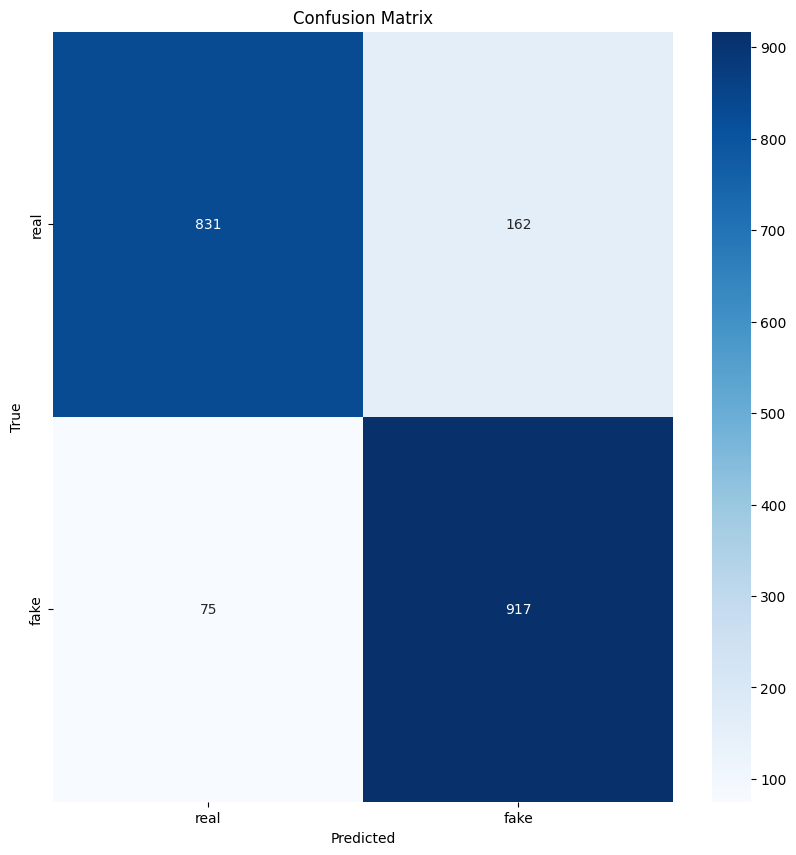

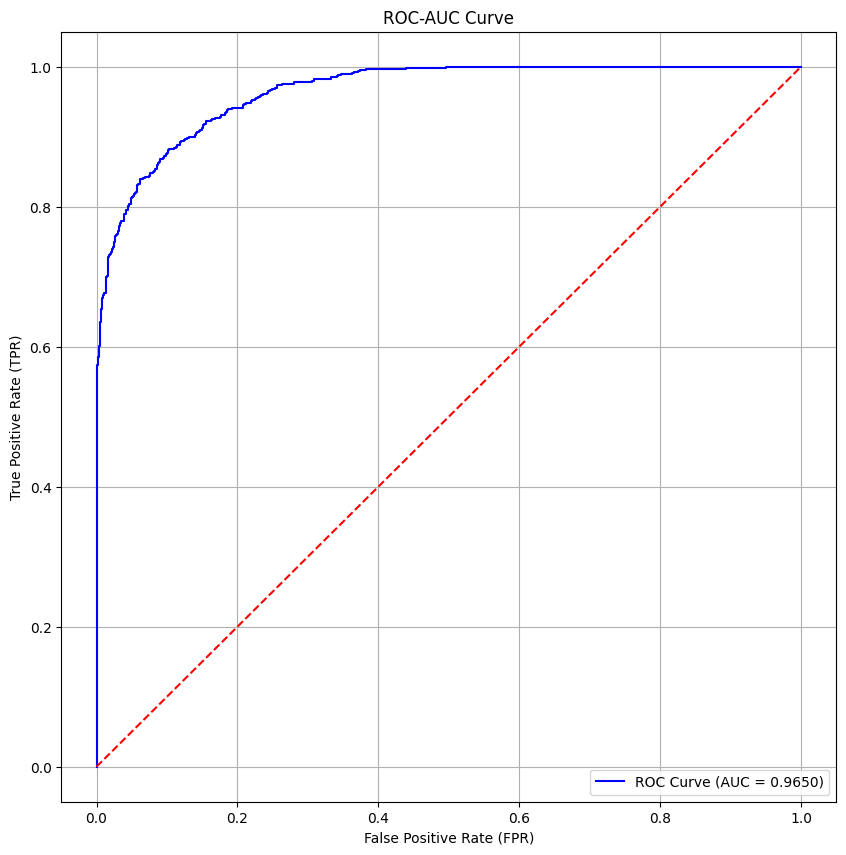

In [32]:
# Evaluate the model and get results
results = evaluate_and_visualize_model(model, test_loader, device)

# Plot the confusion matrix
plot_confusion_matrix(results['conf_matrix'], class_names=['real', 'fake'], save_path='best_model_test_set_cf.png')

# Plot the ROC-AUC curve
plot_roc_curve(results['test_labels'], results['test_probabilities'], results['roc_auc'], save_path='best_model_test_set_roc.png')

### Combining vaidationl and test set and then testing model on a bigger test set

In [33]:
# Combine val_dataset and test_dataset into a single larger dataset
combined_test_dataset = ConcatDataset([val_dataset, test_dataset])

# Create a DataLoader for the combined test dataset
combined_test_loader = DataLoader(combined_test_dataset, batch_size=32, shuffle=True)

Testing the model: 100%|██████████| 125/125 [00:43<00:00,  2.87it/s]


Test Loss: 0.2618, Test Accuracy: 0.8776
Test Precision: 0.8501, Test Recall: 0.9169, Test F1-Score: 0.8822
Test ROC-AUC: 0.9618
Confusion Matrix:
[[1664  321]
 [ 165 1820]]


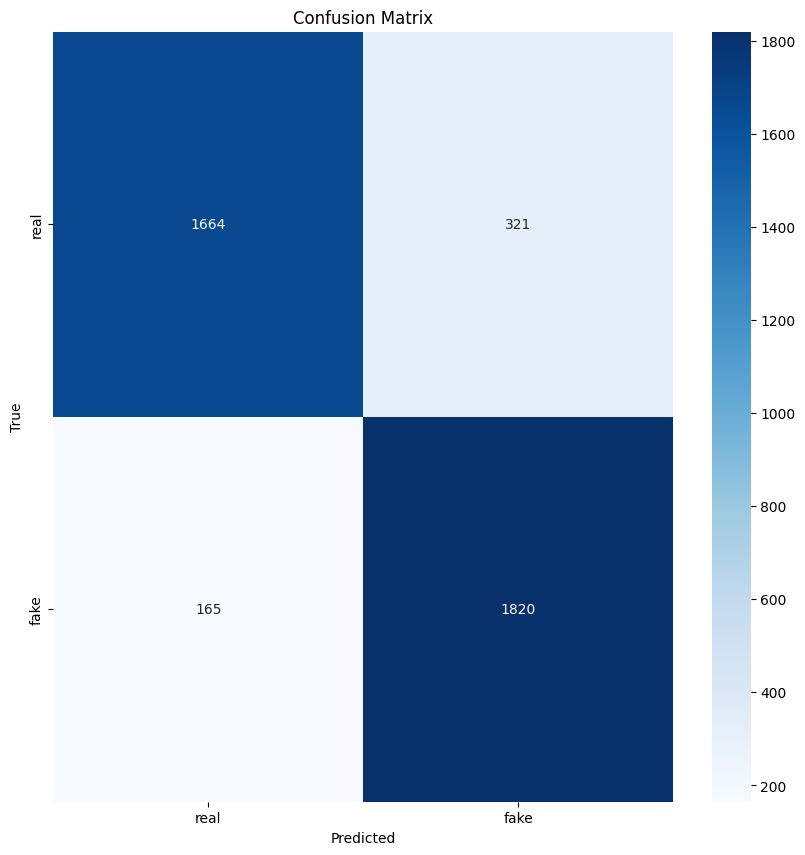

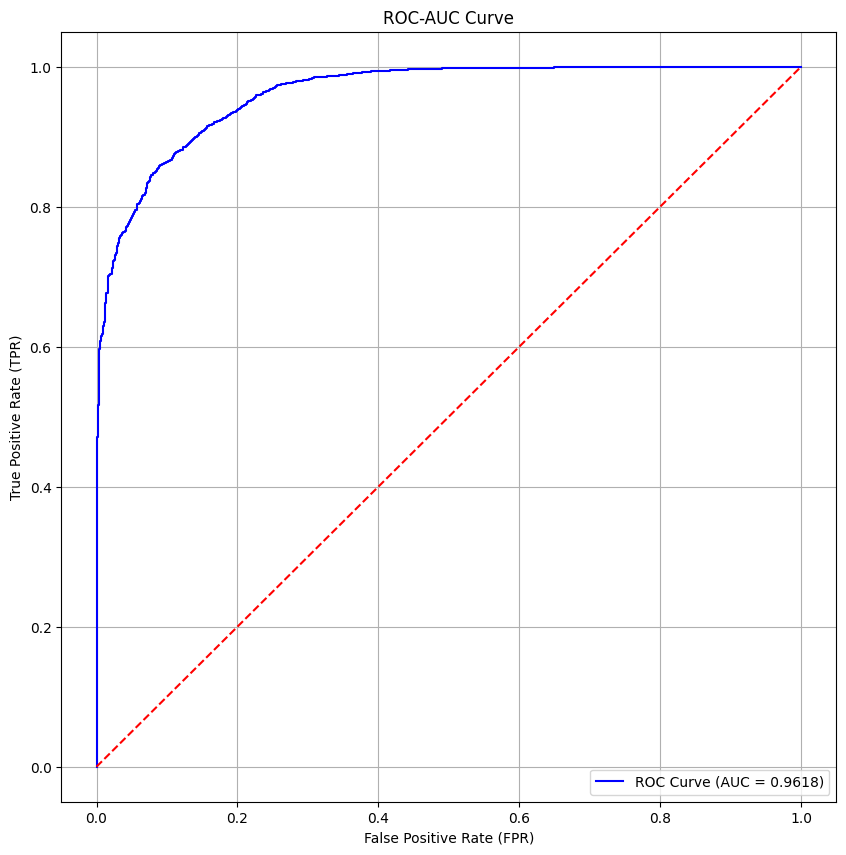

In [34]:
# Evaluate the model on the combined test set (validation + test)
results = evaluate_and_visualize_model(model, combined_test_loader, device)

# Plot the confusion matrix for the combined test set
# Plot the confusion matrix
plot_confusion_matrix(results['conf_matrix'], class_names=['real', 'fake'], save_path='best_model_combined_set_cf.png')

# Plot the ROC-AUC curve
plot_roc_curve(results['test_labels'], results['test_probabilities'], results['roc_auc'], save_path='best_model_combined_set_roc.png')